# Energy Consumption Forecast

Table of Contents:

1. Data Analysis
    - Data Description
    - Data Loading and Cleanup
    - Exploratory Data Analysis (EDA)
        - Outlier Removal
        - Distribution Plot
        - Full Data Plot
        - Daily Data Plot
        - Weekly Data Plot
        - Feaure Expansion
        - Box Plots
    - Data 
        - Time-Series Split
        - Forecasting Horizon
        - Lagged Features
2. Machine Learning
    - Model Creation and Hyperparameter Tuning
    - Evaluating the Past
    - Predicting the Future
    - Feature Importance
    - Addendum
3. Conclusions

**Problem Statement**: The volatile energy market is unsure of future energy consumption. Departments of Energy Need expert opinion on the future demand of electrical energy in the Eastern part of the US.

**Objective**: Train a Machine Learning Model to predict energy consumption in the future based on current data. Backtest the model.

# Data Analysis

## Data Description

Source: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

The data has 145366 entries for energy consumption of the Eastern part of the US as handled by PJM (PJM Interconnection LLC), a regional transmission organization coordinating the transfer of electricity across multiple power grids in America. The columns in this dataset are:

- Datetime (hourly from December 2002 to February 2018)
- PJME_MW (Current reading of energy transfered per unit of time in Megawatts)

## Data Loading and Cleanup

In [220]:
#Loading libraries and data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_style('ticks')
sns.color_palette("tab10")
import numpy as np

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb

In [221]:
data = pd.read_csv('PJME_hourly.csv')
data

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [222]:
#Getting an overview of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [223]:
#Check for null values
data.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [224]:
#Check for duplicates
data.duplicated().sum()

0

In [225]:
#Changing object type to datetime
data['Datetime'] = pd.to_datetime(data['Datetime'] )

In [226]:
#Reindexing data by date
data.set_index('Datetime', inplace=True)

## Exploratory Data Analysis

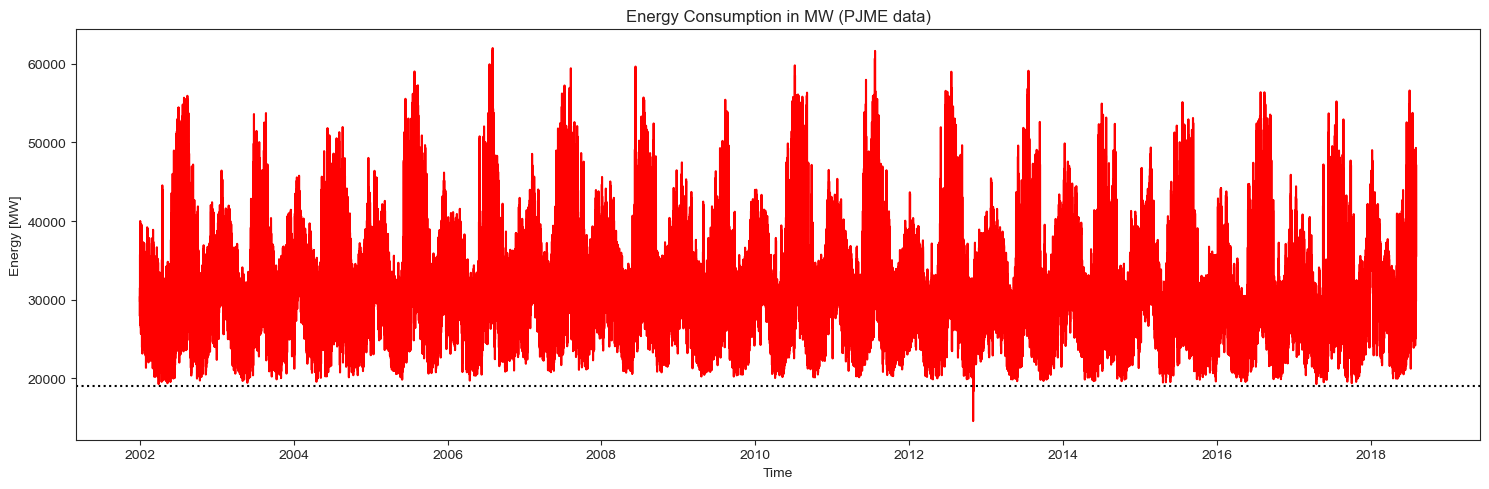

In [227]:
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=data, x='Datetime', y='PJME_MW', color='r')
plt.axhline(19_000, ls='dotted', color='k')
plt.title('Energy Consumption in MW (PJME data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyTimeOutliers.png', bbox_inches='tight')
plt.show()

Around the year 2013, the data shows an anomalous dip in energy consumption well below 15000 MW. This seems unreasonable and is likely an error in the data. Such data needs to be removed in order that our predictive model performs better by not training on anomalous data.

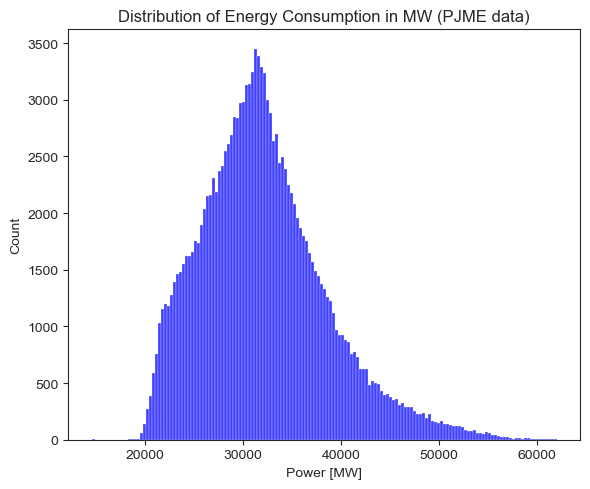

In [228]:
#Distribution Plot for energy consumption (with outliers)
fig = plt.figure(figsize=(6,5))
sns.histplot(data=data, x='PJME_MW', color='b')
plt.title('Distribution of Energy Consumption in MW (PJME data)')
plt.xlabel('Power [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyDistributionOutlier.png', bbox_inches='tight')
plt.show()

### Outlier Removal

In [229]:
#Removing outliers (below 19,000 MW)
data = data[data['PJME_MW'] >= 19000]

### Distribution Plot

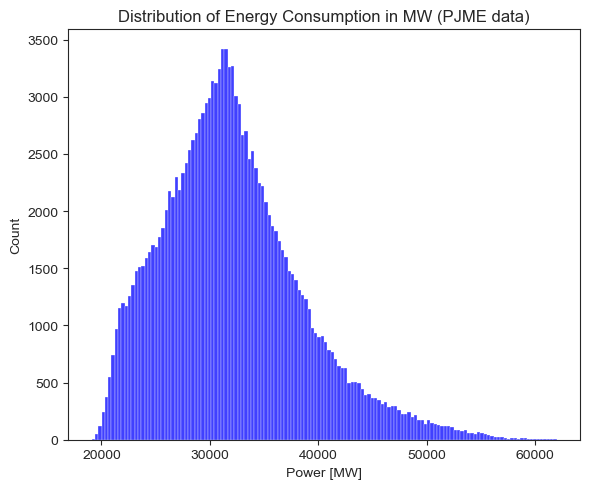

In [230]:
#Distribution Plot for energy consumption (outliers removed)
fig = plt.figure(figsize=(6,5))
sns.histplot(data=data, x='PJME_MW', color='b')
plt.title('Distribution of Energy Consumption in MW (PJME data)')
plt.xlabel('Power [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyDistributionFixed.png', bbox_inches='tight')
plt.show()

Having removed the outliers, we can plot the energy data once again:

### Full Data Plot

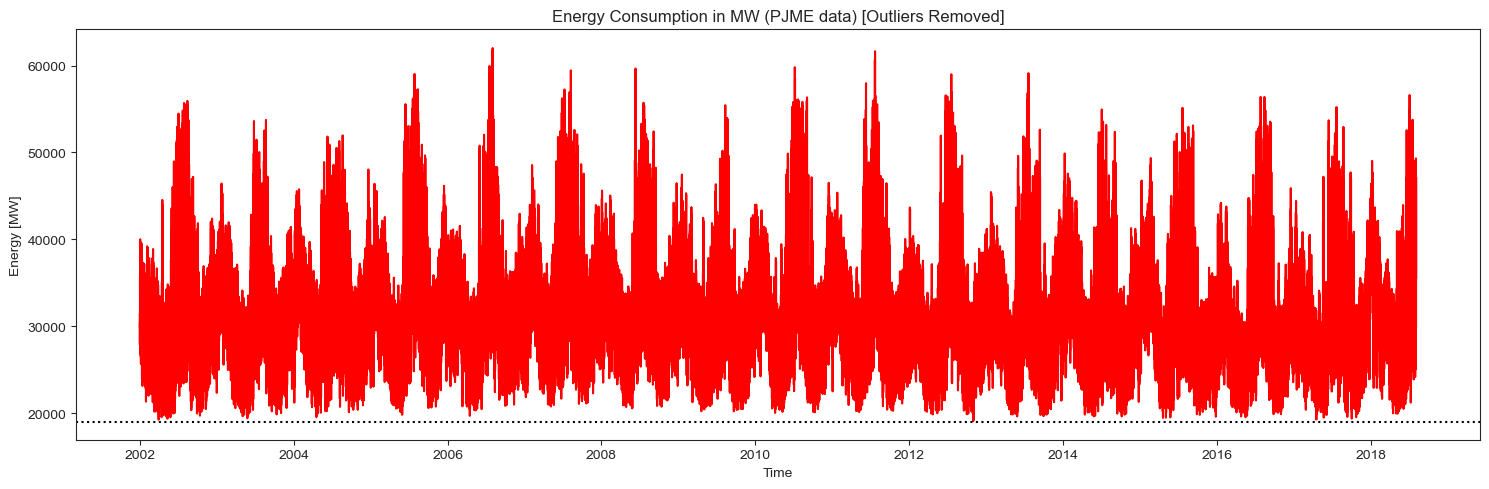

In [231]:
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=data, x='Datetime', y='PJME_MW', color='r')
plt.axhline(19_000, ls='dotted', color='k')
plt.title('Energy Consumption in MW (PJME data) [Outliers Removed]')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyTimeFixed.png', bbox_inches='tight')
plt.show()

### Daily Data Plot

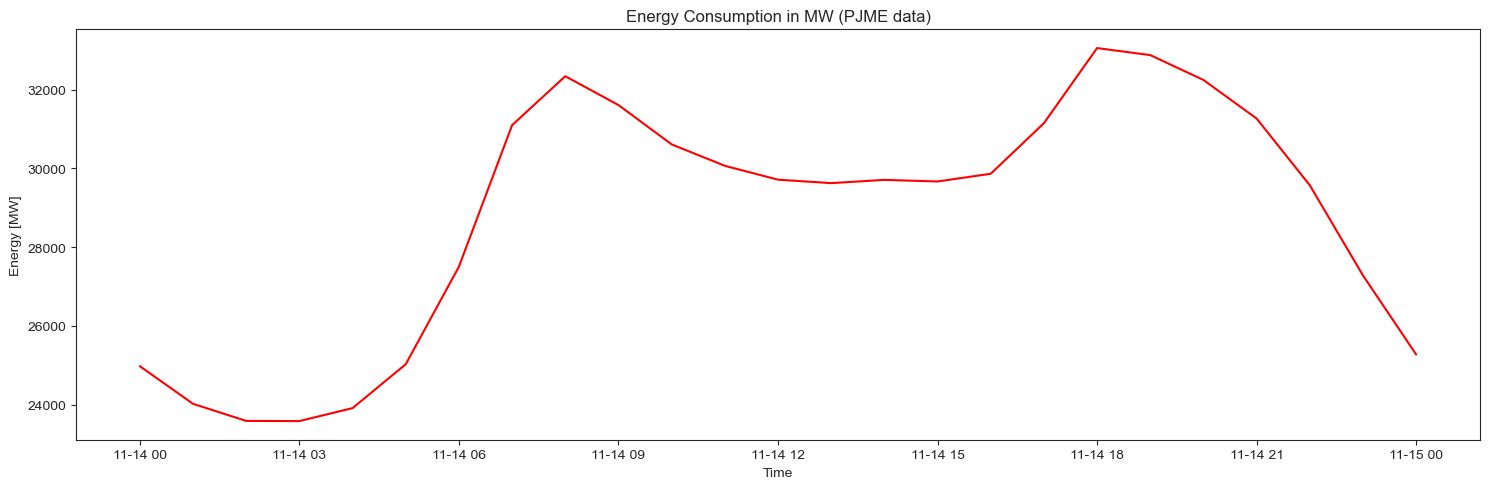

In [232]:
#Plotting daily data
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=data[(data.index >=  '2016-11-14 00:00:00') & (data.index <=  '2016-11-15 00:00:00')], x='Datetime', y='PJME_MW', color='r')
plt.title('Energy Consumption in MW (PJME data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyTimeDaily.png', bbox_inches='tight')
plt.show()

Daily energy consumption data is telling of the fact that energy consumption peaks around 8 a.m. in the morning, regresses back to a lower level, and then peaks at around 6 p.m. in the evening, after which it decreases to a relatively low level. This kind of pattern in energy consumption is perfectly understandable when considering the daily cycle of an average citizen: sleep, waking up and work, rest, dinner and diversion, and all around again.

### Weekly Data Plot

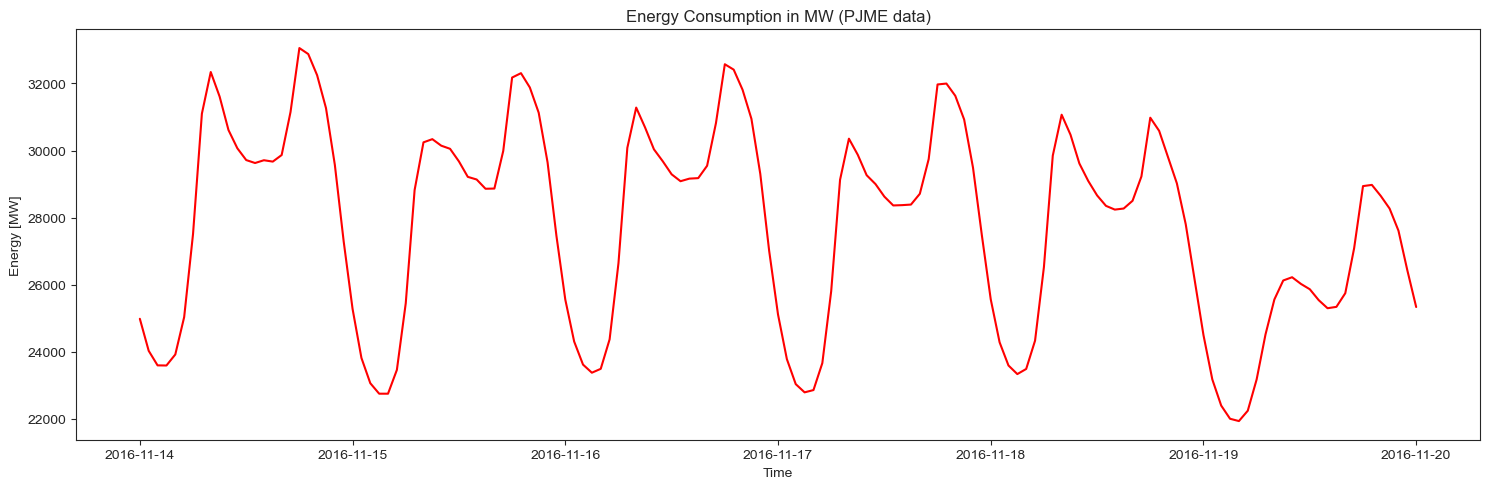

In [233]:
#Plotting weekly data
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=data[(data.index >=  '11-14-2016') & (data.index <=  '11-20-2016')], x='Datetime', y='PJME_MW', color='r')
plt.title('Energy Consumption in MW (PJME data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyTimeWeekly.png', bbox_inches='tight')
plt.show()

Weekly data indicates that total energy consumption is actually lower on weekends (Saturdays and especially Sundays). This is likely due to the fact that the weekends are rest days for most workers. The absence of work that requires electrical power, when aggregated across various work sectors, creates noticeable relief for the power grid.

### Feature Expansion

In [234]:
#Creating features for our ML model based on time series data
def create_features(df):
    data = df.copy()
    data["Year"] = data.index.year
    data["Quarter"] = data.index.quarter
    data["Day_of_year"] = data.index.dayofyear
    data["Month"] = data.index.month
    data["Day_of_week"] = data.index.dayofweek
    data["Hour"] = data.index.hour
    return data

In [235]:
data_boxplots = create_features(data)
data_boxplots

,PJME_MW,Year,Quarter,Day_of_year,Month,Day_of_week,Hour
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,2002,4,365,12,1,1
2002-12-31 02:00:00,25147.0,2002,4,365,12,1,2
2002-12-31 03:00:00,24574.0,2002,4,365,12,1,3
2002-12-31 04:00:00,24393.0,2002,4,365,12,1,4
2002-12-31 05:00:00,24860.0,2002,4,365,12,1,5
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018,1,1,1,0,20
2018-01-01 21:00:00,43751.0,2018,1,1,1,0,21
2018-01-01 22:00:00,42402.0,2018,1,1,1,0,22


### Boxplots

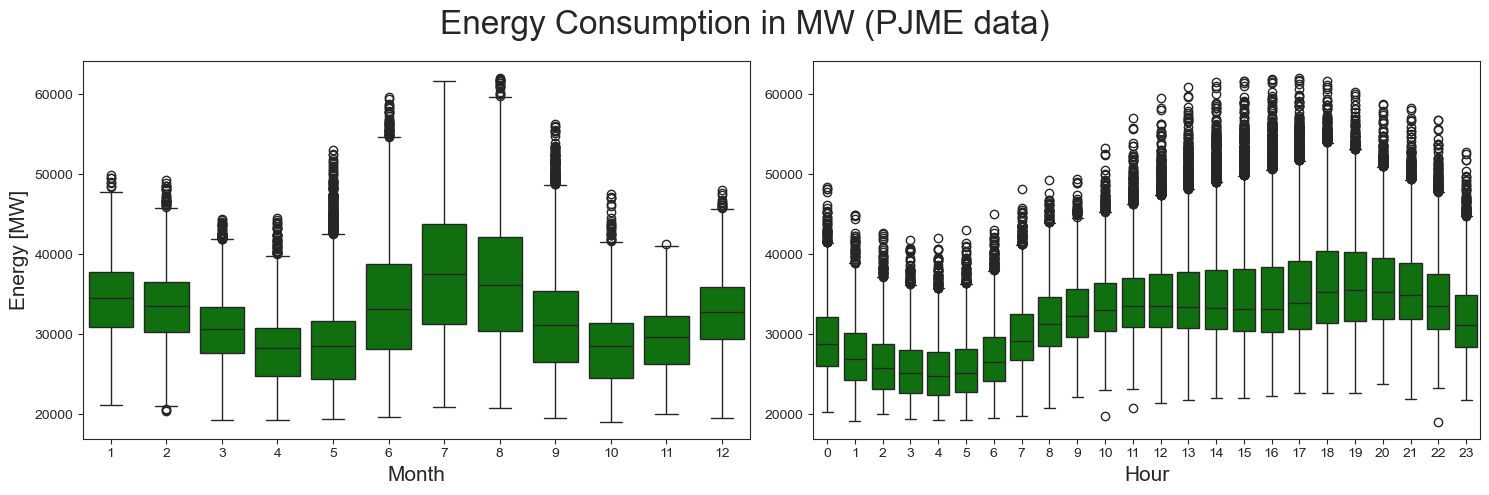

In [236]:
#Box plots
fig, ax= plt.subplots(1,2, figsize=(15,5))
sns.boxplot(data=data_boxplots, x='Month', y='PJME_MW', ax=ax[0], color='green')
sns.boxplot(data=data_boxplots, x='Hour', y='PJME_MW', ax=ax[1], color='green')
plt.suptitle('Energy Consumption in MW (PJME data)', fontsize=24)

ax[0].set_xlabel("Month", fontsize= 15)
ax[1].set_xlabel("Hour", fontsize= 15)

ax[0].set_ylabel('Energy [MW]', fontsize= 15)
ax[1].set_ylabel('')

plt.tight_layout()
plt.savefig('images/01_EnergyTimeBoxplot.png', bbox_inches='tight')
plt.show()

We repeat our conclusions regarding the variations in energy consumption across the hours of the day. Monthly time-series data shows that energy consumption peaks most prominently in the summer months, when cooling devices are in use, and also in the winter months, when heating devices are usually under load. The transitory periods of spring and autumn are not as heavy in regards to the expenditure of electrical energy.

## Data Preprocessing

For training our model, we will use 80% of all data. This means that data from 2002 to 2015 will be used for training, while we will use the remaining data for cross-validation and testing. When using a cross-validation set for building our time-series predictive model, it is imperative that the test data is at a later point in time than the train data. Doing cross-validation otherwise would result in data leakage that would give us a false impression of our model being better than it actually is.

### Time-Series Split

In [237]:
#Initializing a TimeSeriesSplit generator for time-series cross-validation
time_ser_split = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
data = data.sort_index() #data needs to be sorted in respect to time beforehand
data

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


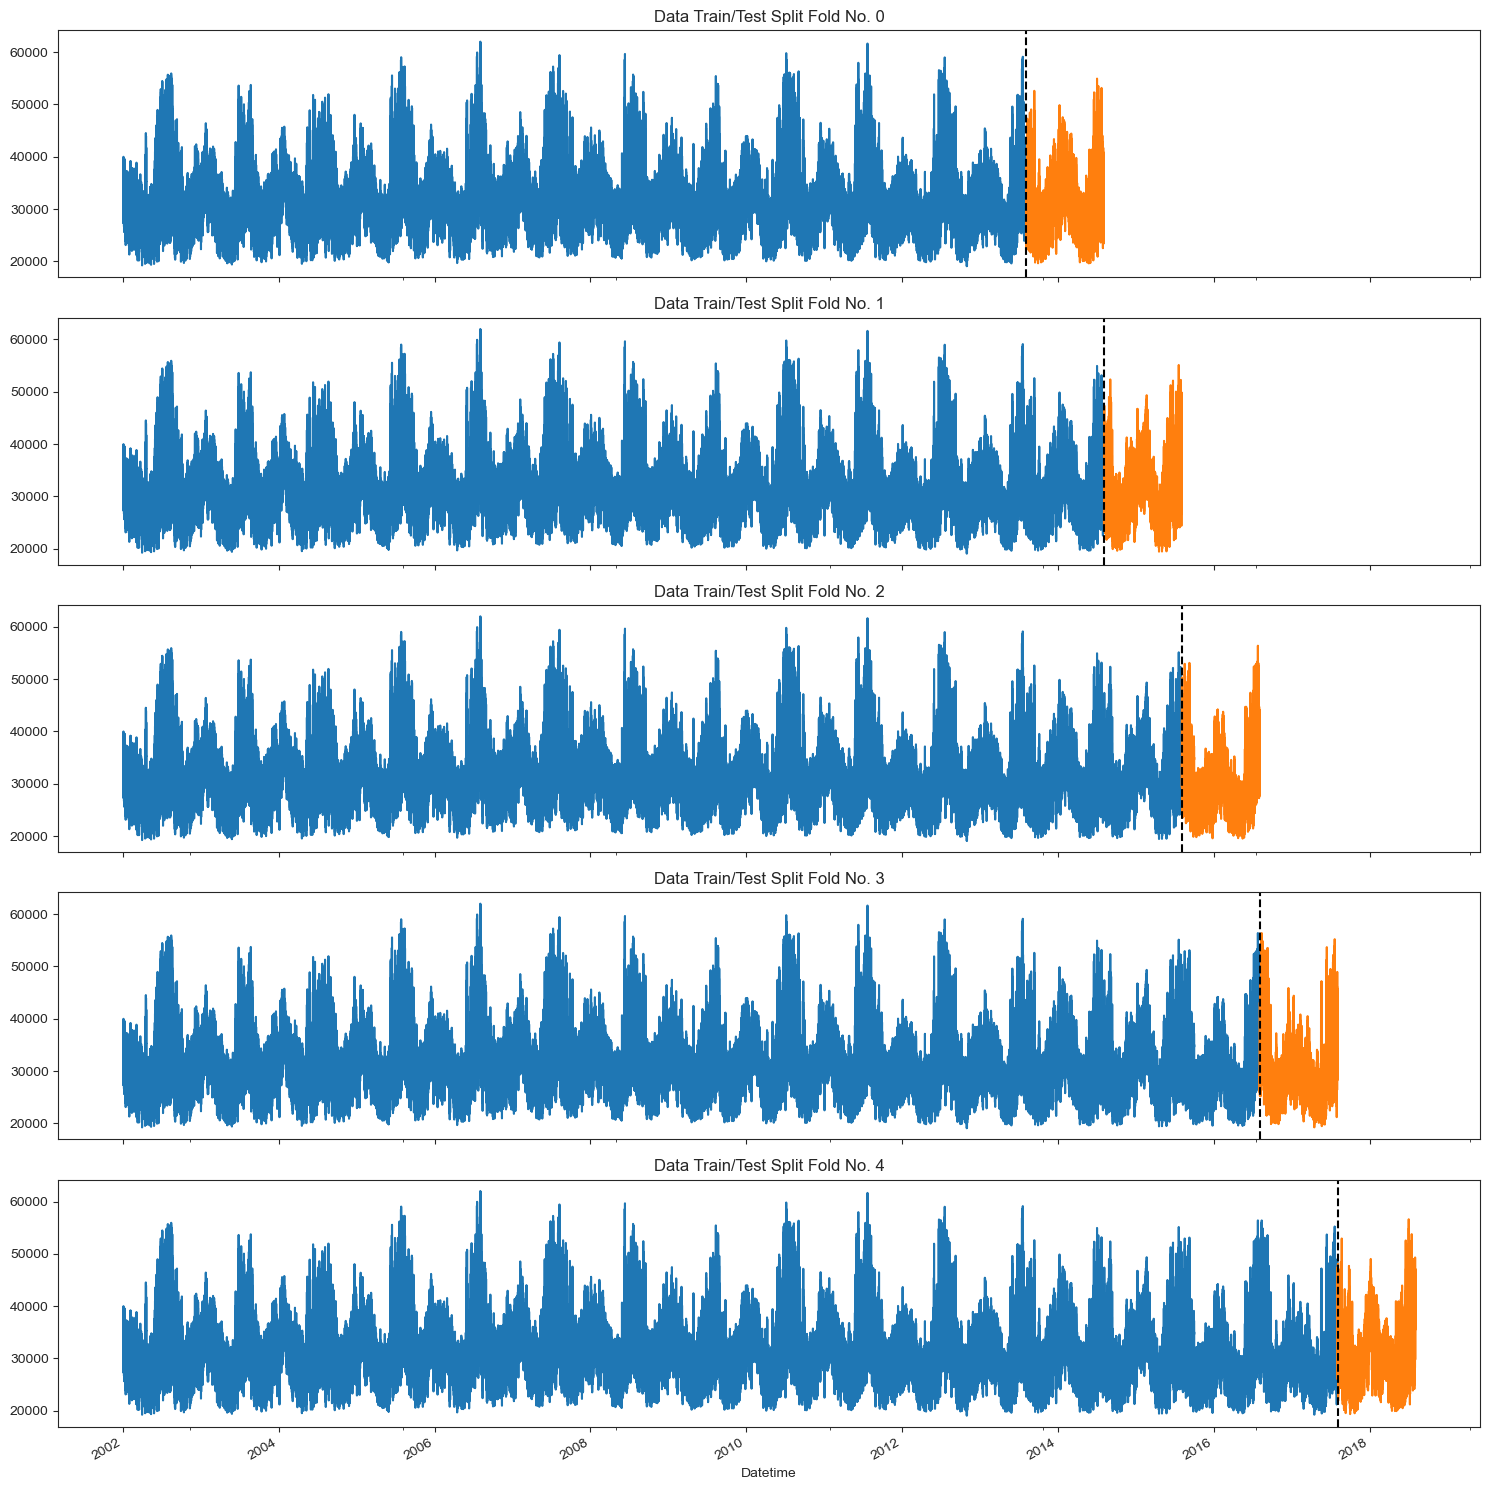

In [238]:
#Visualizing this time-series cross-validation procedure
fig, ax = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0
for train_index, test_index in time_ser_split.split(data):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    train['PJME_MW'].plot(ax=ax[fold], label='Training Set', title=f'Data Train/Test Split Fold No. {fold}')
    test['PJME_MW'].plot(ax=ax[fold], label='Test Set')
    ax[fold].axvline(test.index.min(), color='k', ls='--')
    fold += 1

plt.tight_layout()
plt.savefig('images/01_TimeSeriesSplit.png', bbox_inches='tight')
plt.show()

### Forecasting Horizon

A Forecasting Horizon is the length of time into which our model will try to predict the energy consumption. Forecasting Horizons can be short-term (less than three months) and long term (more than two years). The longer the Forecasting Horizon, the lower the accuracy of the predictive model. For our example, the Forecasting Horizon will be around 1 year.

In [239]:
data

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


### Lagged Features


Lagged Features are really new features made up of variables that were targets (x) amount of time in the past; in our case, we use energy consumption target values at time $s$ as features in the current point in time $t$, where $s<t$.

We will use a dictionary for mapping Lagged Features to our data:

In [240]:
target_map = data['PJME_MW'].to_dict(); target_map

{Timestamp('2002-01-01 01:00:00'): 30393.0,
 Timestamp('2002-01-01 02:00:00'): 29265.0,
 Timestamp('2002-01-01 03:00:00'): 28357.0,
 Timestamp('2002-01-01 04:00:00'): 27899.0,
 Timestamp('2002-01-01 05:00:00'): 28057.0,
 Timestamp('2002-01-01 06:00:00'): 28654.0,
 Timestamp('2002-01-01 07:00:00'): 29308.0,
 Timestamp('2002-01-01 08:00:00'): 29595.0,
 Timestamp('2002-01-01 09:00:00'): 29943.0,
 Timestamp('2002-01-01 10:00:00'): 30692.0,
 Timestamp('2002-01-01 11:00:00'): 31395.0,
 Timestamp('2002-01-01 12:00:00'): 31496.0,
 Timestamp('2002-01-01 13:00:00'): 31031.0,
 Timestamp('2002-01-01 14:00:00'): 30360.0,
 Timestamp('2002-01-01 15:00:00'): 29798.0,
 Timestamp('2002-01-01 16:00:00'): 29720.0,
 Timestamp('2002-01-01 17:00:00'): 31271.0,
 Timestamp('2002-01-01 18:00:00'): 35103.0,
 Timestamp('2002-01-01 19:00:00'): 35732.0,
 Timestamp('2002-01-01 20:00:00'): 35639.0,
 Timestamp('2002-01-01 21:00:00'): 35285.0,
 Timestamp('2002-01-01 22:00:00'): 34007.0,
 Timestamp('2002-01-01 23:00:00'

In [241]:
#Using the energy consumption value of the same day last year as a lagging feature
def add_lags(df):
    data['lag1'] = (data.index-pd.Timedelta('364 days')).map(target_map)
    data['lag2'] = (data.index-pd.Timedelta('798 days')).map(target_map)
    data['lag3'] = (data.index-pd.Timedelta('1092 days')).map(target_map)
    return df

In [242]:
add_lags(data)
create_features(data)

,PJME_MW,lag1,lag2,lag3,Year,Quarter,Day_of_year,Month,Day_of_week,Hour
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,NaN,NaN,NaN,2002,1,1,1,1,1
2002-01-01 02:00:00,29265.0,NaN,NaN,NaN,2002,1,1,1,1,2
2002-01-01 03:00:00,28357.0,NaN,NaN,NaN,2002,1,1,1,1,3
2002-01-01 04:00:00,27899.0,NaN,NaN,NaN,2002,1,1,1,1,4
2002-01-01 05:00:00,28057.0,NaN,NaN,NaN,2002,1,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,42256.0,39558.0,38804.0,2018,3,214,8,3,20
2018-08-02 21:00:00,43256.0,41210.0,39211.0,38748.0,2018,3,214,8,3,21
2018-08-02 22:00:00,41552.0,39525.0,38098.0,37330.0,2018,3,214,8,3,22


# Machine Learning

## Model Creation and Hyperparameter Tuning

In [178]:
## Finding optimal hyperparameters for our XGBoost model over 
# different TimeSeriesSplit cross-validation folds
parameters = {
    'max_depth': [3,5,7],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'n_estimators': [1000, 3000]
}


def find_best_algorithm(X, y):
    scores = {}
    mse = make_scorer(mean_squared_error, greater_is_better=False)

    gs = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=parameters, cv=time_ser_split, scoring=mse)
    gs.fit(X,y)
    scores.update({
        'Best Score': gs.best_score_,
        'Best Parameters': gs.best_params_,
        'Best RMSE': np.sqrt(mean_squared_error(y, gs.predict(X)))
    })
    return pd.DataFrame(scores, columns=['Best Score', 'Best Parameters', 'Best RMSE']).sort_values(by='Best RMSE', ascending=False)

In [243]:
best_model_df = find_best_algorithm(data.drop('PJME_MW', axis='columns'), data['PJME_MW'])

KeyboardInterrupt: 

In [ ]:
best_model_df

,Best Score,Best Parameters,Best RMSE
learning_rate,-1.381494e+07,0.001,3337.192881
max_depth,-1.381494e+07,5.000,3337.192881
n_estimators,-1.381494e+07,3000.000,3337.192881


The optimal hyperparameters are the ones shown above.

## Evaluating the Past

We can use the optimal hyperparameters to train our model up to a specific point in time, and see how accurate predictions after that point are. It should be noted that this particular part of past data does not achieve the best RMSE results with the same hyperparameters. It is shown only as an illustration.

In [244]:
#Plotting prediction VS real past data (one week)
data_past = data[data.index < '01-01-2015'].copy()
data_future =data[data.index >= '01-01-2015'].copy()

X_train = data_past.drop('PJME_MW', axis='columns')
Y_train = data_past['PJME_MW']

X_test = data_future.drop('PJME_MW', axis='columns')
Y_test = data_future['PJME_MW']

xgb_reg = xgb.XGBRegressor(n_estimators=3000, max_depth=5, learning_rate=0.001)
xgb_reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=100)

[0]	validation_0-rmse:6446.21264	validation_1-rmse:6517.88359
[100]	validation_0-rmse:6074.03316	validation_1-rmse:6130.72625
[200]	validation_0-rmse:5750.31865	validation_1-rmse:5795.75474
[300]	validation_0-rmse:5469.58607	validation_1-rmse:5507.80693
[400]	validation_0-rmse:5227.25682	validation_1-rmse:5262.75722
[500]	validation_0-rmse:5018.56746	validation_1-rmse:5055.34975
[600]	validation_0-rmse:4839.67726	validation_1-rmse:4879.71508
[700]	validation_0-rmse:4686.40098	validation_1-rmse:4732.14692
[800]	validation_0-rmse:4555.62669	validation_1-rmse:4608.10807
[900]	validation_0-rmse:4444.36890	validation_1-rmse:4504.75594
[1000]	validation_0-rmse:4350.22369	validation_1-rmse:4418.57822
[1100]	validation_0-rmse:4270.73299	validation_1-rmse:4347.67166
[1200]	validation_0-rmse:4203.69107	validation_1-rmse:4289.29692
[1300]	validation_0-rmse:4147.12529	validation_1-rmse:4241.58851
[1400]	validation_0-rmse:4099.46928	validation_1-rmse:4202.50185
[1500]	validation_0-rmse:4059.39474	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

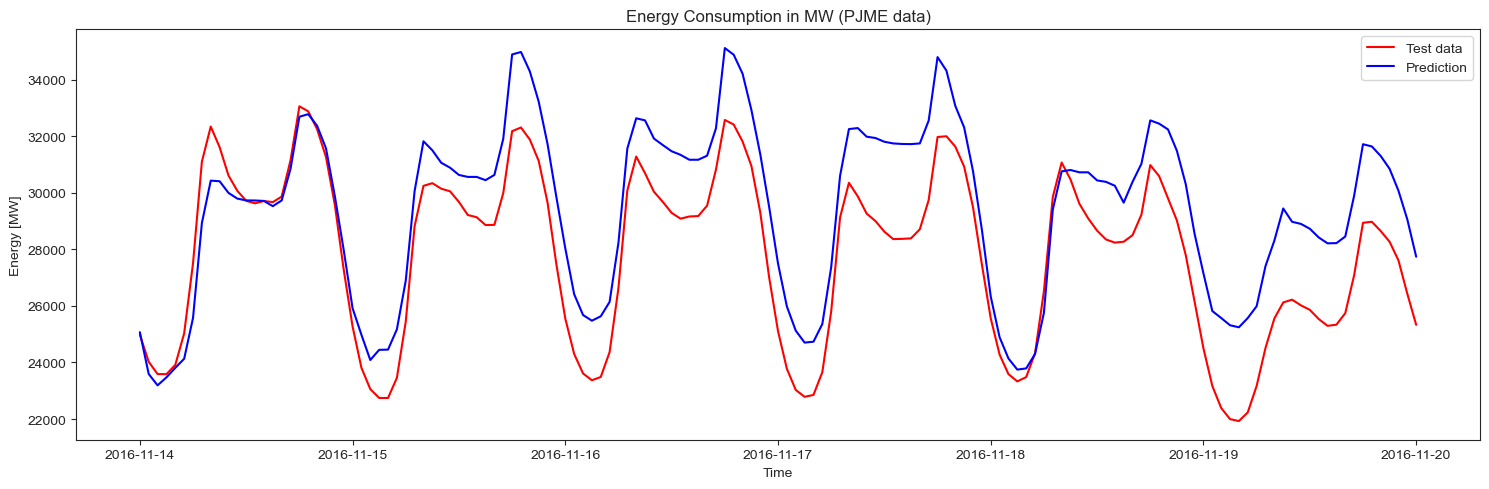

In [245]:
data_future['predictions'] = xgb_reg.predict(X_test)

fig = plt.figure(figsize=(15,5))
sns.lineplot(data=data_future[(data_future.index >=  '11-14-2016') & (data_future.index <=  '11-20-2016')], x=data_future[(data_future.index >=  '11-14-2016') & (data_future.index <=  '11-20-2016')].index, y='PJME_MW', color='r')
sns.lineplot(data=data_future[(data_future.index >=  '11-14-2016') & (data_future.index <=  '11-20-2016')], x=data_future[(data_future.index >=  '11-14-2016') & (data_future.index <=  '11-20-2016')].index, y='predictions', color='b')

plt.title('Energy Consumption in MW (PJME data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')

train_label = mlines.Line2D([], [], color='r', ls='-', label='Test data')
test_label = mlines.Line2D([], [], color='b', ls='-', label='Prediction')

plt.legend(handles=[train_label, test_label])
plt.tight_layout()
plt.savefig('images/01_PredictionVSTest.png', bbox_inches='tight')
plt.show()

## Predicting the Future
To predict future data, it is useful to retrain our model on _all_ available data, not just what was, until now, the test set. Aside from this, all we have to do is create a DataFrame with time series indices (along with the corresponding features - including lag features) that can be run through our prediction algorithm. We will also be using the previously optimized hyperparameters to make our predictions more accurate.

In [249]:
#Training our final model for future predictions
df = add_lags(create_features(data))

X_all = df.drop('PJME_MW', axis='columns')
Y_all = df['PJME_MW']

xgb_reg = xgb.XGBRegressor(n_estimators=3000, max_depth=5, learning_rate=0.001)
xgb_reg.fit(X_all, Y_all, eval_set=[(X_all, Y_all)], verbose=100)

[0]	validation_0-rmse:6458.26693
[100]	validation_0-rmse:6070.64998
[200]	validation_0-rmse:5731.82336
[300]	validation_0-rmse:5436.30429
[400]	validation_0-rmse:5178.54165
[500]	validation_0-rmse:4954.78999
[600]	validation_0-rmse:4760.19365
[700]	validation_0-rmse:4591.98636
[800]	validation_0-rmse:4446.13745
[900]	validation_0-rmse:4320.39775
[1000]	validation_0-rmse:4207.86326
[1100]	validation_0-rmse:4105.00322
[1200]	validation_0-rmse:4015.58287
[1300]	validation_0-rmse:3938.74257
[1400]	validation_0-rmse:3870.45237
[1500]	validation_0-rmse:3809.35519
[1600]	validation_0-rmse:3757.60129
[1700]	validation_0-rmse:3712.22015
[1800]	validation_0-rmse:3667.35434
[1900]	validation_0-rmse:3621.42799
[2000]	validation_0-rmse:3579.86014
[2100]	validation_0-rmse:3543.90424
[2200]	validation_0-rmse:3512.42890
[2300]	validation_0-rmse:3483.13917
[2400]	validation_0-rmse:3455.61171
[2500]	validation_0-rmse:3429.91434
[2600]	validation_0-rmse:3407.17401
[2700]	validation_0-rmse:3386.79960
[280

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [252]:
#Creating skeleton DataFrame
future_df = pd.DataFrame(index=pd.date_range('2018-08-03', '2019-08-01', freq='1h'))
future_df ['isFuture'] = True
df ['isFuture'] = False
df_and_future = pd.concat([df, future_df])

df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_df_w_features = df_and_future.query('isFuture').copy()
future_df_w_features.drop('isFuture', axis='columns', inplace=True)

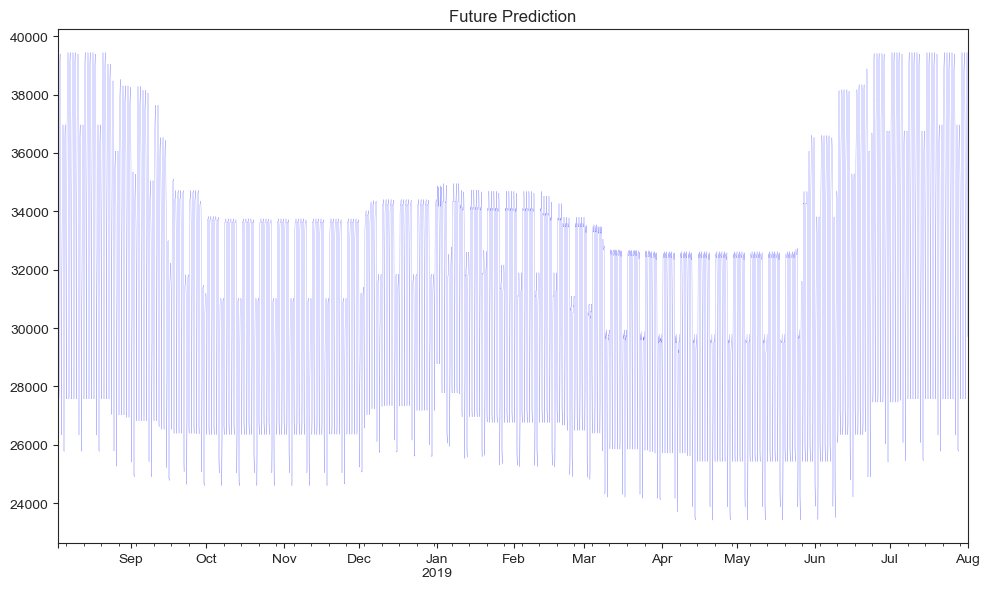

In [253]:
future_df_w_features['prediction'] = xgb_reg.predict(future_df_w_features.drop('PJME_MW', axis='columns'))
future_df_w_features['prediction'].plot(figsize=(10,6), lw=0.1, color='b', title='Future Prediction')
plt.tight_layout()
plt.savefig('images/01_PredictionFuture.png', bbox_inches='tight')
plt.show()

In [254]:
#Saving our XGBoost model
xgb_reg.save_model('EnergyPredictionModel.json')

## Feature Importance

<Figure size 1500x500 with 0 Axes>

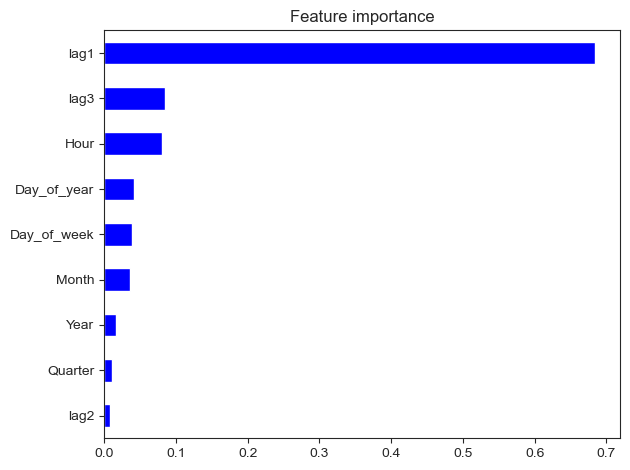

In [ ]:
#Plotting feature importances
feature_df = pd.DataFrame(data=xgb_reg.feature_importances_, index=future_df_w_features.drop(['prediction', 'PJME_MW'], axis='columns').columns, columns=['Importance']).sort_values(by = 'Importance', ascending=False)#, columns=['Importance']).sort_values(by='Importance', ascending=False)
fig = plt.figure(figsize=(15,5))
feature_df.plot(kind='barh', color='b').invert_yaxis()
plt.title('Feature importance')
plt.legend().remove()

plt.tight_layout()
plt.savefig('images/01_FeatureImportance.png', bbox_inches='tight')
plt.show()

### Addendum: (previously used code)

The error used in this exercise is the RMSE (Root Mean Squared Error). The reason for using this specific metric is that it penalizes large errors much more that it does relatively smaller ones. This is important for time-series predictions, as we want to follow the general trend and punish any blatant prediction mistakes.

In [ ]:
#Calculating RMSE score 
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
score

3733.2674865025883

In [ ]:
#Calculating absolute error and querying for the dates with the 10 biggest prediction errors
test['error_abs'] = abs( test['prediction'] - test['PJME_MW'] )
test['date'] = test['Datetime'].dt.strftime('%m-%d')
errors_df = test.groupby('date')['error_abs'].mean().sort_values(ascending=False)
errors_df.head(10)

date
09-09    8745.467448
09-08    7059.862142
02-20    6895.568197
09-10    6565.747965
02-21    6500.469421
03-01    6192.610962
06-12    6044.651632
08-14    5961.105496
02-29    5699.639160
08-13    5579.326036
Name: error_abs, dtype: float64

The above table shows that, when averaged over the years from 2002 to 2018, the most error-prone dates are those in the month of September, as well as those of late February and early March. This is possibly because these seasonally transitory periods are exceptions to the time-series rule that the model has learned. In other words, as the graphs shown above clearly show, the trend in energy consumption during Fall and Spring is diminished in overall range, resulting in slight problems for the predictive model.

# Conclusions

We can sum up our findings regarding this Energy Consumption dataset in a few bulletpoint:
- Energy Consumption data pertaining to the Eastern part of USA is quite normally distributed with only small amount of skew to the right
- Energy Consumption peaks in the Summer months, and is followed by Winter months; in Spring and Fall periods it is comparatively lower and of a different pattern
- During the weekends, Energy Consumption is lower as compared to the rest of the week. It is thought that this is due to it being a holiday and workplaces being empty.
- Energy Consumption peaks around 8 a.m. in the morning, regresses back to a lower level, and then peaks at around 6 p.m. in the evening, after which it decreases to a relatively low level.
- Our Machine Learning model predicts past test data quite well, and we can be confident that the future forecasting is also quite accurate. 
- The most important feature in the Machine Learning Regression Model is the first lagged feature, namely the value of energy consumption in megawatts exactly one year ago.